# 1 Introdução


Vamos agora usar a mesma metodologia mas para um modelo 3D. Vamos usar o modelo PUNQ_S3 para Imex com parâmetros ajustados para somente um fluido, "água".
O modelo possui 6 poços produtores, nenhum injetor e um aquífero analítico acoplado. Os poços são controlados por vazão de líquido imposta e pressão mínima.

O modelo PUNQ_S3.dat modificado está na pasta anexa e possui somente dois anexos "PunQ-S3_IMEX_coord.GRDECL" e "PunQ-S3_IMEX_zcorn.GRDECL". Rodando o arquivo nós vamos exportar as propriedades de pressão do grid e pressão de fundo dos poços e vazões por completação.


![Texto alternativo](punq.png)


## 1.1 Rodar os simulador

Rode o arquivo PUNQ_S3.dat

## 1.2 Visualização

Observe os resultados no Results do CMG ou qualquer outro pós processador. É um modelo bem leve, roda em poucos segundos, e é pra ter produção somente de água durante 20 anos.

## 1.3 Exportar os dados

Existem várias formas de se exportar os dados simulados para o Python ou qualquer outra linguagem de programação. Fique à vontade para fazer da sua forma. Neste trabalho foi utilizado originalmente o Results Report do CMG. 
Rode os arquivos "*.rwd" no "Report.exe" do CMG. Como saída vão ser gerados 3 arquivos .rwo

# 2 OpInf nos dados de grid

## 2.1 Inicialização

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
n=19*28*5 #número de células


In [17]:
# carregar dados de vazão por completação
dados = np.loadtxt('PUNQ_S3_Q.rwo', skiprows=6)
U=dados[1:,1:].T
p=U.shape[0]
tempo=dados[:,0]
tempo[0]=0.0
dt=tempo[1:]-tempo[:-1]


k=tempo.shape[0]-1 #número de passos de tempo, exceto o tempo inicial

# carregar dados de pressão de fundo por poço
dados = np.loadtxt('PUNQ_S3_PWF.rwo', skiprows=6)
PWF=dados[1:,1:].T
q=PWF.shape[0]


In [19]:

# carregar dados de pressão do grid

def extrair_matriz_pressao(filepath):
    with open(filepath, 'r') as f:
        linhas = f.readlines()

    tempos = []
    matrizes = []
    linha_atual = 0
    while linha_atual < len(linhas):
        if linhas[linha_atual].startswith('**  TIME'):
            tempo = linhas[linha_atual].split('=')[1].strip()
            tempos.append(tempo)
            # Encontrar 'PRES ALL'
            while not linhas[linha_atual].strip().startswith('PRES ALL'):
                linha_atual += 1
            linha_atual += 1

            bloco = []
            while linha_atual < len(linhas):
                if linhas[linha_atual].startswith('** K'):
                    linha_atual += 1
                    celula_dados = []
                    # 3 linhas de valores por bloco
                    for _ in range(3):
                        if linha_atual < len(linhas):
                            valores = [float(x) for x in linhas[linha_atual].split()]
                            celula_dados.extend(valores)
                            linha_atual += 1
                    bloco.extend(celula_dados)
                elif linhas[linha_atual].startswith('**  TIME') or linha_atual == len(linhas) - 1:
                    break
                else:
                    linha_atual += 1
            matrizes.append(bloco)
        else:
            linha_atual += 1

    matriz_pressao = np.array(matrizes).T  # Cada coluna é um tempo
    return matriz_pressao

dados =extrair_matriz_pressao("PUNQ_S3_P.rwo")
Xorig=np.delete(dados,1,axis=1)  # eliminando o tempo correspondente a t=0.01
x0=Xorig[:,0].copy()
X=Xorig[:,1:].copy()

### 🧩 Tabela de Células de Completação

| Poço      | I   | J   | K     | Célula # |
|-----------|-----|-----|-------|----------|
| PRO-01    | 10  | 22  | 4     | 2005     |
| PRO-01    | 10  | 22  | 5     | 2537     |
| PRO-04    | 9   | 17  | 4     | 1909     |
| PRO-04    | 9   | 17  | 5     | 2441     |
| PRO-05    | 17  | 11  | 3     | 1271     |
| PRO-05    | 17  | 11  | 4     | 1803     |
| PRO-11    | 11  | 24  | 3     | 1512     |
| PRO-11    | 11  | 24  | 4     | 2044     |
| PRO-12    | 15  | 12  | 4     | 1820     |
| PRO-12    | 15  | 12  | 5     | 2352     |
| PRO-15    | 17  | 22  | 4     | 2012     |

## 2.2 Histórico e Previsão

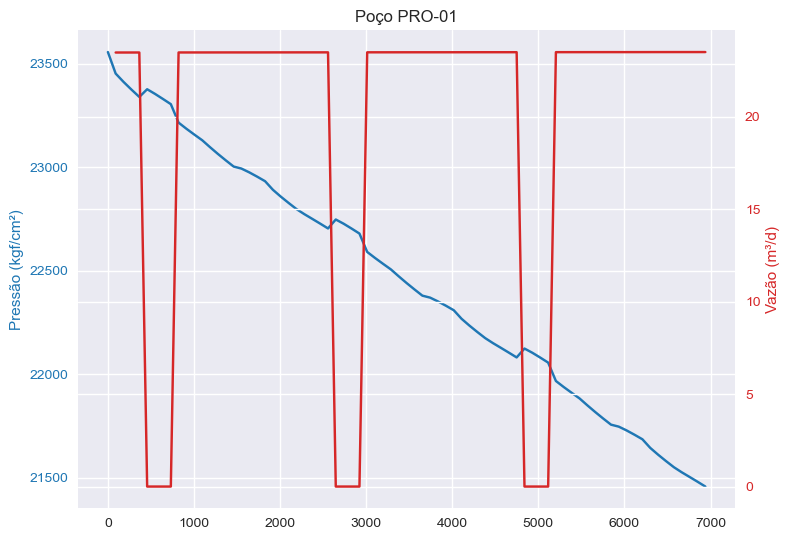

In [23]:

plt.style.use('seaborn-v0_8')

fig, ax1 = plt.subplots()

# Primeiro gráfico: Pressão
ax1.plot(tempo, Xorig[2004, :], color='tab:blue', label='Pressão')
ax1.set_ylabel("Pressão (kgf/cm²)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title("Poço PRO-01")

# Segundo gráfico: Vazão (eixo y secundário)
ax2 = ax1.twinx()
ax2.plot(tempo[1:], U[0, :], color='tab:red', label='Vazão')
ax2.set_ylabel("Vazão (m³/d)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

In [25]:
kh=int(k/2)  # usando metade do tempo total para histórico e o resto para previsão

## 2.3 Redução de ordem

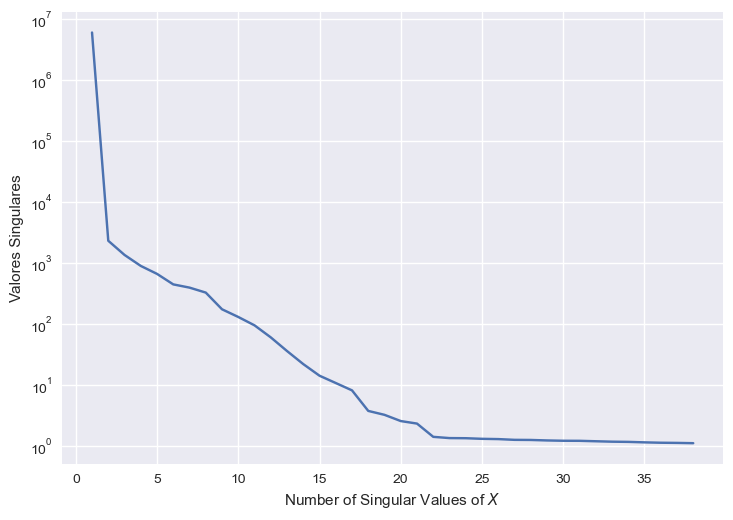

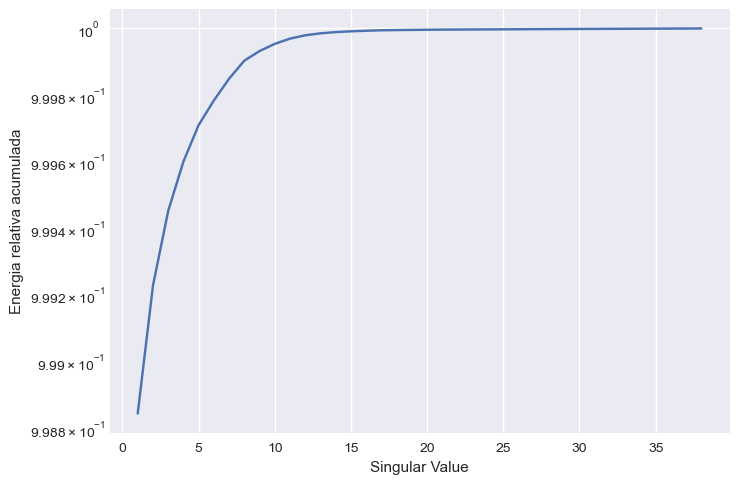

In [28]:
Phi,S,W = np.linalg.svd(X[:,:kh], full_matrices=False)

plt.style.use('seaborn-v0_8')

x = range(1, len(S)+1)
plt.plot(x,S)
fig = plt.gcf()
fig.set_size_inches(12.8/1.5, 8.8/1.5)
plt.yscale("log")
plt.xlabel("Number of Singular Values of $X$")
plt.ylabel("Valores Singulares")
# plt.grid()
plt.show()


plt.semilogy(x,np.cumsum(S) / np.sum(S))  #pode-se usar também o quadrado dos valores singulares
plt.xlabel("Singular Value")
plt.ylabel("Energia relativa acumulada")
# plt.grid()
plt.show()

In [29]:
#escolhendo r
r=14

Phir=Phi[:,:r].copy()

# projetando
Xr=Phir.T@X[:,:kh]
x0r=Phir.T@x0

#calculando a derivada. para problemas mais complexos, usar derivada ao menos de 4a ordem
Xrdot=np.zeros((r,kh))
Xrdot[:,0]=(Xr[:,0]-x0r)/dt[0]
Xrdot[:,1:]=(Xr[:,1:]-Xr[:,:-1])/dt[1:kh]

## 2.4 Inferindo as matrizes

In [33]:
# Inferindo as matrizes
Gamma=np.vstack((Xr,U[:,:kh]))
O=np.zeros((r,r+p))

O,*_=np.linalg.lstsq(Gamma.T,Xrdot.T,rcond=None)
O=O.T

Ar=O[:,0:r]
Br=O[:,r:r+p]

## 2.5 Calculando novos estados

In [36]:
# calculando novas matrizes
Xrhat=np.zeros((r,k+1))
Xrhat[:,0]=x0r


for i in range(1,k+1):
    mat1=np.eye(r)-dt[i-1]*Ar
    mat2=Xrhat[:,i-1]+dt[i-1]*Br@U[:,i-1]
    Xrhat[:,i]=np.linalg.solve(mat1,mat2)
Xhat=Phir@Xrhat

## 2.6 Visualização dos resultados

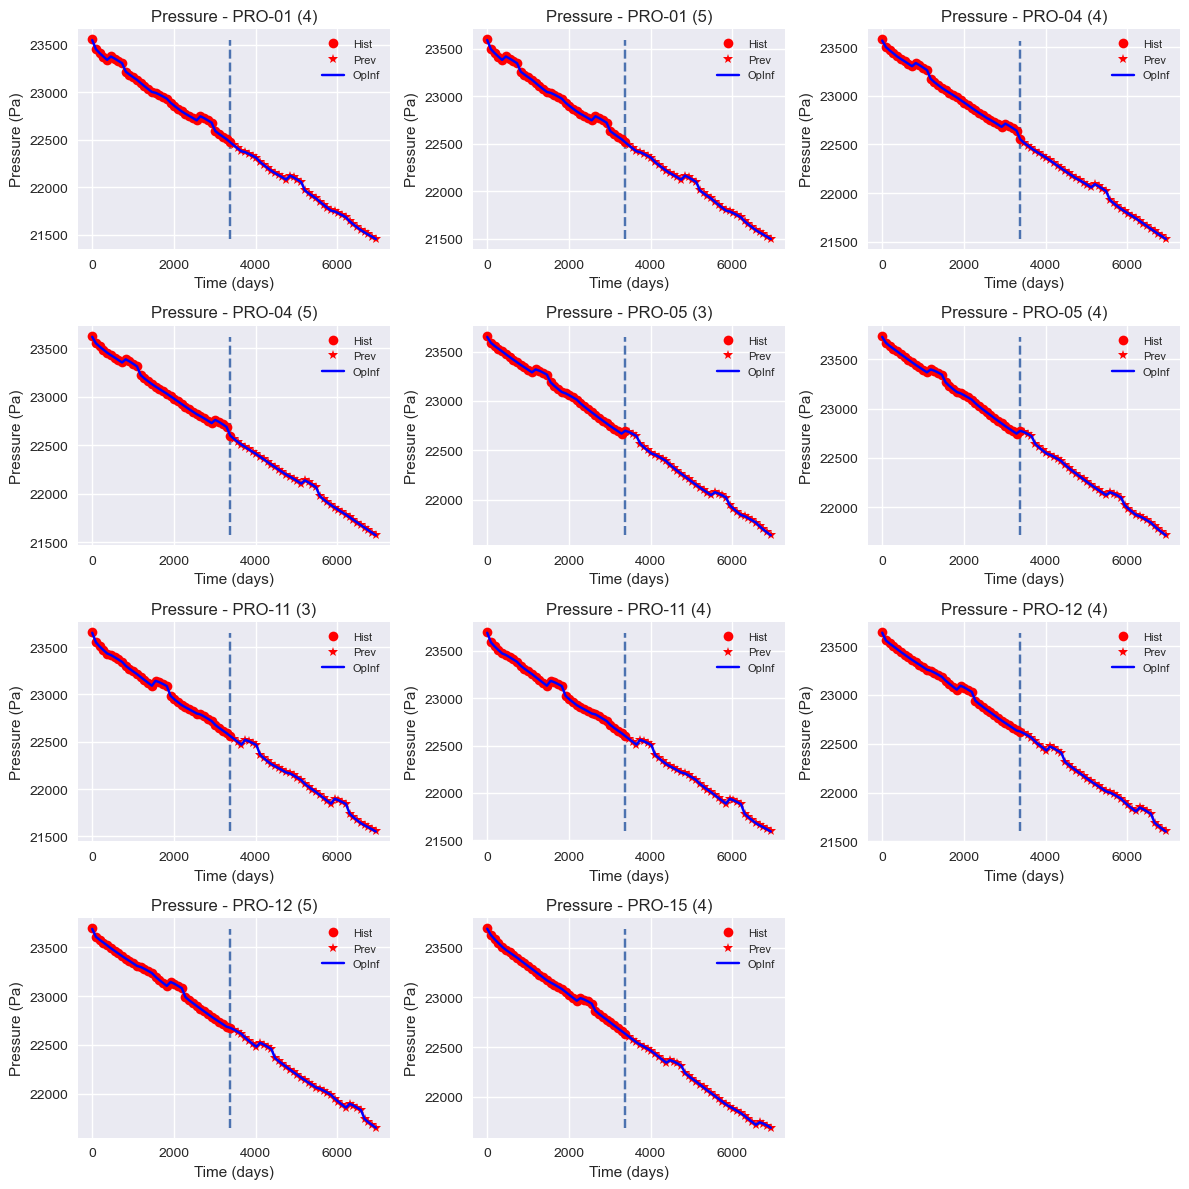

In [39]:

# Lista das células zero-based (número da célula - 1)
celulas = [2005, 2537, 1909, 2441, 1271, 1803, 1512, 2044, 1820, 2352, 2012]
celulas = [c - 1 for c in celulas]  # zero-based

# Rótulos dos poços
rotulos = {
    2004: "PRO-01 (4)",
    2536: "PRO-01 (5)",
    1908: "PRO-04 (4)",
    2440: "PRO-04 (5)",
    1270: "PRO-05 (3)",
    1802: "PRO-05 (4)",
    1511: "PRO-11 (3)",
    2043: "PRO-11 (4)",
    1819: "PRO-12 (4)",
    2351: "PRO-12 (5)",
    2011: "PRO-15 (4)"
}

# Criar figura com subplots: 6 linhas, 2 colunas
fig, axs = plt.subplots(4, 3, figsize=(12, 12))
axs = axs.flatten()

for idx, cid in enumerate(celulas):
    ax = axs[idx]
    ax.plot([tempo[kh-1], tempo[kh-1]], [np.min(Xhat[cid, :]), np.max(Xhat[cid, :])], "--")
    ax.plot(tempo[:kh], Xorig[cid, :kh], 'ro', label="Hist")
    ax.plot(tempo[kh:], Xorig[cid, kh:], 'r*', label="Prev")
    ax.plot(tempo, Xhat[cid, :], 'b', label="OpInf")
    ax.set_title(f"Pressure - {rotulos[cid]}")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Pressure (Pa)")
    ax.legend(fontsize=8)

# Se houver menos subplots que espaços, remover extras
for j in range(len(celulas), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


# 3 OpInf nos dados de poço

Como estamos mais interessados em observar os dados de pressão de fundo do poço, vamos aplicar o OpInf mais uma vez para resolver a seguinte equação de espaço de estados:
$$\mathbf{y}(t)=\mathbf{Cx}(t)+\mathbf{Du}(t)$$

Onde $\mathbf{y}(t)$ nesse caso representa as pressões de fundo (pwf). O vetor de estados $\mathbf{x}(t)$ a ser usado nesse caso é o mesmo calculado no passo passado. Para evitar mais etapas vamos usar já o vetor de estados na forma reduzida.

## 3.1 Inferindo as matrizes

In [44]:
GammaY=np.vstack((Xrhat[:,1:kh+1],U[:,:kh]))

OY=np.zeros((q,r+p))

OY,*_=np.linalg.lstsq(GammaY.T,PWF[:,:kh].T,rcond=None)
OY=OY.T

Chat=OY[:,0:r]
Dhat=OY[:,r:r+p]

## 3.2 Calculando as novas saídas

In [47]:
PWFhat=Chat@Xrhat[:,1:]+Dhat@U
np.linalg.norm(PWF[:,:kh]-OY@GammaY,'fro')

0.00571909489010375

## 3.3 Visualização dos resultados

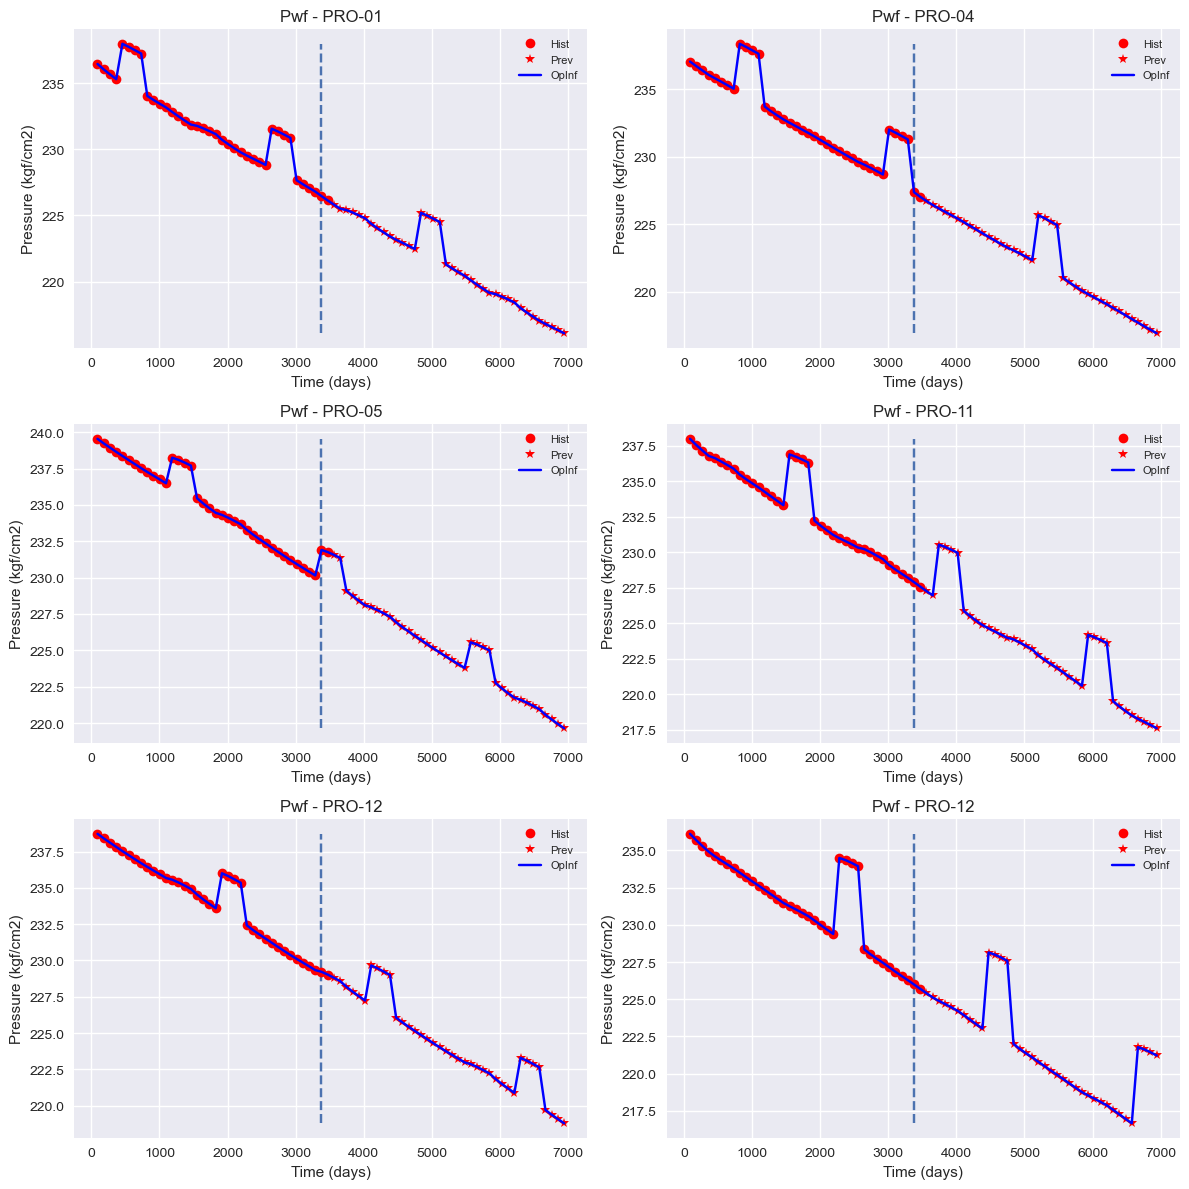

In [50]:

# Lista dos poços
posicao = [1, 2, 3, 4, 5, 6]
posicao = [c - 1 for c in posicao]  # zero-based

# Rótulos dos poços
rotulos = {
    0: "PRO-01",
    1: "PRO-04",
    2: "PRO-05",
    3: "PRO-11",
    4: "PRO-12",
    5: "PRO-12"
}

# Criar figura com subplots: 6 linhas, 2 colunas
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()

for idx, cid in enumerate(posicao):
    ax = axs[idx]
    ax.plot([tempo[kh-1], tempo[kh-1]], [np.min(PWFhat[cid, :]), np.max(PWFhat[cid, :])], "--")
    ax.plot(tempo[1:kh+1], PWF[cid, :kh], 'ro', label="Hist")
    ax.plot(tempo[kh+1:], PWF[cid, kh:], 'r*', label="Prev")
    ax.plot(tempo[1:], PWFhat[cid, :], 'b', label="OpInf")
    ax.set_title(f"Pwf - {rotulos[cid]}")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Pressure (kgf/cm2)")
    ax.legend(fontsize=8)

# Se houver menos subplots que espaços, remover extras
for j in range(len(posicao), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

Com tudo finalizado, que tal testar com valores diferentes de r e kh???